In [1]:
from qepy import *
from yambopy import *
from qepy import PwIn
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
# Create the input files
def get_inputfile():
    """ Define a Quantum espresso input file for silicon
    """
    qe = PwIn()
    qe.atoms = [['Si',[0.125,0.125,0.125]],
                ['Si',[-.125,-.125,-.125]]]
    qe.atypes = {'Si': [28.086,"Si.pbe-mt_fhi.UPF"]}

    qe.control['prefix'] = "'%s'"%prefix
    qe.control['wf_collect'] = '.true.'
    qe.control['pseudo_dir'] = "'../pseudos'"
    qe.system['celldm(1)'] = 10.3
    qe.system['ecutwfc'] = 30
    qe.system['occupations'] = "'fixed'"
    qe.system['nat'] = 2
    qe.system['ntyp'] = 1
    qe.system['ibrav'] = 2
    qe.electrons['conv_thr'] = 1e-8
    return qe

#scf
def scf():
    if not os.path.isdir('scf'):
        os.mkdir('scf')
    qe = get_inputfile()
    qe.control['calculation'] = "'scf'"
    qe.kpoints = scf_kpoints
    qe.write('scf/%s.scf'%prefix)

#nscf
def nscf():
    if not os.path.isdir('nscf'):
        os.mkdir('nscf')
    qe = get_inputfile()
    qe.control['calculation'] = "'nscf'"
    qe.electrons['diago_full_acc'] = ".true."
    qe.electrons['conv_thr'] = 1e-8
    qe.system['nbnd'] = 30
    qe.system['force_symmorphic'] = ".true."
    qe.kpoints = nscf_kpoints
    qe.write('nscf/%s.nscf'%prefix)

#bands
def bands():
    if not os.path.isdir('bands'):
        os.mkdir('bands')
    qe = get_inputfile()
    qe.control['calculation'] = "'bands'"
    qe.electrons['diago_full_acc'] = ".true."
    qe.electrons['conv_thr'] = 1e-8
    qe.system['nbnd'] = 8
    qe.system['force_symmorphic'] = ".true."
    qe.ktype = 'crystal'
    qe.set_path(p)
    qe.write('bands/%s.bands'%prefix)

def run_scf(nthreads=1):
    print("running scf:")
    os.system("cd scf; mpirun -np %d %s -inp %s.scf > scf.log"%(nthreads,pw,prefix))
    print("done!")

def run_nscf(nthreads=1):
    print("running nscf:")
    os.system("cp -r scf/%s.save nscf/"%prefix)
    os.system("cd nscf; mpirun -np %d %s -inp %s.nscf > nscf.log"%(nthreads,pw,prefix))
    print("done!")

def run_bands(nthreads=1):
    print("running bands:")
    os.system("cp -r scf/%s.save bands/"%prefix)
    os.system("cd bands; mpirun -np %d %s -inp %s.bands > bands.log"%(nthreads,pw,prefix))
    print("done!")

def run_plot():
    print("running plotting:")
    xml = PwXML(prefix='si',path='bands')
    xml.plot_eigen(p)

In [3]:
#Define some global variable
scf_kpoints  = [4,4,4]
nscf_kpoints = [4,4,4]
prefix = 'si'
matdyn = 'matdyn.x'
q2r =    'q2r.x'
pw = 'pw.x'
ph = 'ph.x'
p = Path([ [[1.0,1.0,1.0],'G'],
           [[0.0,0.5,0.5],'X'],
           [[0.0,0.0,0.0],'G'],
           [[0.5,0.0,0.0],'L']], [20,20,20])

nthreads = 4

In [4]:
#run the scf calculation
scf()
run_scf(nthreads)

running scf:
done!


In [5]:
#run the nscf calculation
nscf()
run_nscf(nthreads)

running nscf:
done!


running bands:
done!
running plotting:
reading data-file.xml


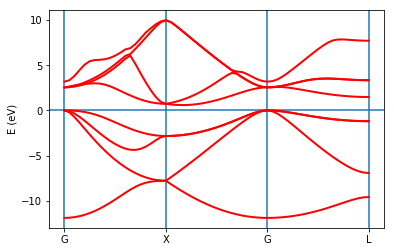

In [6]:
#compute and plot the bands
bands()
run_bands(nthreads)
run_plot()

Repeat the operation of gw_si.py

In [8]:
#setup for the yambo computation. Check if the nscf folder is present
#and convert the qe results in the yambo format. 
yambo =  'yambo'

if not os.path.isdir('gw'):
    os.mkdir('gw')

#check if the nscf cycle is present
if os.path.isdir('nscf/%s.save'%prefix):
    print('nscf calculation found!')
else:
    print('nscf calculation not found!')
    exit() 

#check if the SAVE folder is present
if not os.path.isdir('gw/SAVE'):
    print('preparing yambo gw folder')
    os.system('cd nscf/%s.save; p2y'%prefix)
    os.system('cd nscf/%s.save; yambo'%prefix) #execute yambo without argument
    os.system('mv nscf/%s.save/SAVE gw'%prefix)

nscf calculation found!


In [72]:
#create the yambo input file
# -V all,qp,RL : verbosity
# -p p,c : GW approximations [(p)PA/(c)OHSEX]
# -d : dynamical inverse matrix
# -g n,s,g: Dyson Equation solver [(n)ewton/(s)ecant)/(g)reen]
y = YamboIn('%s -p p -g n -V RL'%yambo,folder='gw')
print(y)
#QPkrange : QP generalized K(points) indices. The format is
#first k-point|last-kpoint|first-band|last-band|
#modifiy the orginal QPkrange field [1,13,1,30] in [1,13,4,5]
QPKrange,_ = y['QPkrange']
y['QPkrange'] = [QPKrange[:2]+[1,5],'']
#add these fields
#Paramter to reduce the number of plane waves with respect to the the DFT-KS calculation
#Convergence test required
y['FFTGvecs'] = [22,'Ry']

y['NGsBlkXp'] = [1,'Ry'] #?

y['BndsRnXp'] = [1,20] #?
#Parameter specifies the lower (occupied) and upper (unoccupied) band in the calculation of W.
#format: lower-band|upper-band|
y['GbndRnge'] = [1,20]
y.write('gw/yambo_gw.in')

em1d
gw0
HF_and_locXC
ppa
EXXRLvcs = 5985.000000 RL
% BndsRnXp
 1 | 30 |   
%
% GbndRnge
 1 | 30 |   
%
dScStep = 0.100000 eV
NGsBlkXp = 1.000000 RL
DysSolver =        'n'
FFTGvecs = 1067.000000 RL
% QPkrange
 1 | 13 | 1 | 30 |   
%
PPAPntXp = 27.211380 eV
% LongDrXp
 1.0 | 0.0 | 0.0 |   
%
GDamping = 0.100000 eV



In [73]:
#mpirun of the yambo computation
print('calculating...')
os.system("cd gw; mpirun -np %d %s -F yambo_gw.in -J gw -C gw"%(nthreads,yambo))

calculating...


0

In [74]:
#Analyse the results using yambo analyser
pack_files_in_folder('gw')
ya_gw = YamboAnalyser('gw')

gw/gw


plot along a path
nkpoints: 13
 -0.09708738   0.09708738   0.09708738  0
 -0.04854369   0.09708738   0.04854369  12
  0.00000000   0.09708738   0.00000000  6
  0.00000000   0.09708738   0.00000000  6
  0.00000000   0.04854369   0.00000000  3
  0.00000000   0.00000000   0.00000000  0
  0.00000000   0.00000000   0.00000000  0
 -0.02427184  -0.02427184   0.02427184  1
 -0.04854369  -0.04854369   0.04854369  2


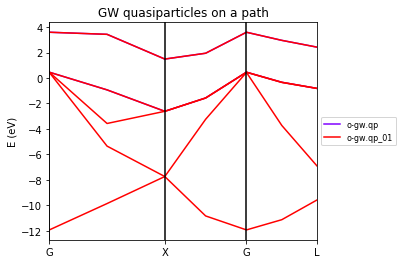

In [75]:
print('plot along a path')
path = [[[1.0,1.0,1.0],'G'],
        [[0.0,0.5,0.5],'X'],
        [[0.0,0.0,0.0],'G'],
        [[0.5,0.0,0.0],'L']]
ya_gw.plot_gw_path('qp',path)

Repeat the operation of gw_conv_si.py

In [10]:
#setup for the yambo computation for the gw_conv folder. Check if the nscf folder is present
#and convert the qe results in the yambo format. 
yambo = 'yambo'

if not os.path.isdir('gw_conv'):
    os.mkdir('gw_conv')

#check if the nscf cycle is present
if os.path.isdir('nscf/%s.save'%prefix):
    print('nscf calculation found!')
else:
    print('nscf calculation not found!')
    exit() 

#check if the SAVE folder is present
if not os.path.isdir('gw_conv/SAVE'):
    print('preparing yambo gw_conv folder')
    os.system('cd nscf/%s.save; p2y'%prefix)
    os.system('cd nscf/%s.save; yambo'%prefix) #execute yambo without argument
    os.system('mv nscf/%s.save/SAVE gw_conv'%prefix)

nscf calculation found!
preparing yambo gw_conv folder


In [11]:
y = YamboIn('%s -p p -g n -V RL'%yambo,folder='gw_conv')
y['GbndRnge'] = [[1,15],'']
y['QPkrange'][0][2:4] = [2,6]
conv = { 'FFTGvecs': [[5,10,15],'Ry'],
        'NGsBlkXp': [[1,2,3], 'Ry'],
        'BndsRnXp': [[1,10],[1,20],[1,30]] }

Increases one parameter at the time, when one is increased the others are in their base value

In [12]:
def run(filename):
        """ Function to be called by the optimize function """
        folder = filename.split('.')[0]
        print(filename,folder)
        os.system('cd gw_conv; mpirun -np %d %s -F %s -J %s -C %s 2> %s.log'%(nthreads,yambo,filename,folder,folder,folder))

In [13]:
y.optimize(conv,run=run)

('reference.in', 'reference')
('NGsBlkXp_00002.in', 'NGsBlkXp_00002')
('NGsBlkXp_00003.in', 'NGsBlkXp_00003')
('BndsRnXp_1_20.in', 'BndsRnXp_1_20')
('BndsRnXp_1_30.in', 'BndsRnXp_1_30')
('FFTGvecs_00010.in', 'FFTGvecs_00010')
('FFTGvecs_00015.in', 'FFTGvecs_00015')


[]

In [23]:
pack_files_in_folder('gw_conv')
#plot the results using yambm analyser
ya_gw_conv = YamboAnalyser('gw_conv')
print(ya_gw_conv)

gw_conv/NGsBlkXp_00003
gw_conv/reference
gw_conv/NGsBlkXp_00002
gw_conv/BndsRnXp_1_30
gw_conv/BndsRnXp_1_20
gw_conv/FFTGvecs_00015
gw_conv/FFTGvecs_00010
reference.json
	o-reference.qp
BndsRnXp_1_30.json
	o-BndsRnXp_1_30.qp
BndsRnXp_1_20.json
	o-BndsRnXp_1_20.qp
NGsBlkXp_00002.json
	o-NGsBlkXp_00002.qp
FFTGvecs_00010.json
	o-FFTGvecs_00010.qp
FFTGvecs_00015.json
	o-FFTGvecs_00015.qp
NGsBlkXp_00003.json
	o-NGsBlkXp_00003.qp



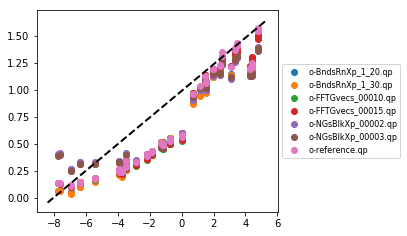

In [24]:
ya_gw_conv.plot_qp_correction('qp')

plot along a path
nkpoints: 13
 -0.09708738   0.09708738   0.09708738  0
 -0.04854369   0.09708738   0.04854369  12
  0.00000000   0.09708738   0.00000000  6
  0.00000000   0.09708738   0.00000000  6
  0.00000000   0.04854369   0.00000000  3
  0.00000000   0.00000000   0.00000000  0
  0.00000000   0.00000000   0.00000000  0
 -0.02427184  -0.02427184   0.02427184  1
 -0.04854369  -0.04854369   0.04854369  2


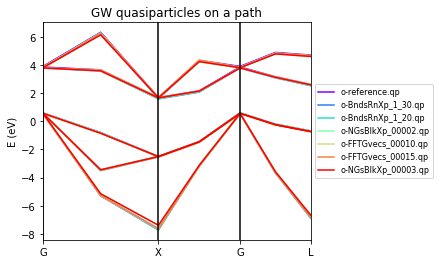

In [25]:
print('plot along a path')
path = [[[1.0,1.0,1.0],'G'],
        [[0.0,0.5,0.5],'X'],
        [[0.0,0.0,0.0],'G'],
        [[0.5,0.0,0.0],'L']]
ya_gw_conv.plot_gw_path('qp',path)
#ya.plot_gw_path('qp',path, cols=(lambda x: x[2]+x[3],2))

Analysis of the yambo output files using the json file related procedure defined in the yambopy analyser. 

In [82]:
# We can also directly read the .json file as a python dictionary
%cd 'gw'
with open('gw.json') as f:
    gwdict = json.load(f)
%cd ../

/home/marco/Data/RICERCA/MANY BODY/Yambo-nb/Si-equilibrium/Nb version of YamboPy Tutorial/gw
/home/marco/Data/RICERCA/MANY BODY/Yambo-nb/Si-equilibrium/Nb version of YamboPy Tutorial


In [83]:
gwdict.keys()

[u'tags',
 u'atompos',
 u'lattice',
 u'atomtype',
 u'alat',
 u'sym_car',
 u'runtime',
 u'data',
 u'kpts_iku',
 u'inputfile']

In [90]:
# The list of quaisparticle energies in yambo is organized as follows:
# K-point Band E0 E-E0 Sc(E0)
gwdict['data']

#meaning of file _01 ????

{u'o-gw.qp': [[1.0, 4.0, 0.0, 0.45486, 1.831885],
  [1.0, 5.0, 2.551396, 1.042565, -3.083382],
  [2.0, 4.0, -0.755416, 0.419124, 1.981396],
  [2.0, 5.0, 1.973283, 0.983112, -3.108838],
  [3.0, 4.0, -1.193028, 0.370914, 2.196421],
  [3.0, 5.0, 1.481409, 0.939244, -3.03619],
  [4.0, 4.0, -1.875226, 0.30408, 2.247731],
  [4.0, 5.0, 1.134926, 0.809255, -2.930648],
  [5.0, 4.0, -2.189226, 0.287017, 2.428394],
  [5.0, 5.0, 1.524587, 0.852982, -3.038514],
  [6.0, 4.0, -1.319742, 0.386037, 2.160004],
  [6.0, 5.0, 2.431065, 0.994539, -3.192577],
  [7.0, 4.0, -2.831735, 0.212607, 2.656301],
  [7.0, 5.0, 0.727806, 0.75929, -2.935658],
  [8.0, 4.0, -3.815314, 0.141739, 2.664612],
  [8.0, 5.0, 4.271985, 0.971582, -3.369467],
  [9.0, 4.0, -0.755415, 0.418641, 1.980726],
  [9.0, 5.0, 1.973334, 0.988205, -3.102833],
  [10.0, 4.0, -1.19303, 0.36938, 2.1945],
  [10.0, 5.0, 1.48145, 0.93898, -3.03673],
  [11.0, 4.0, -2.18921, 0.26927, 2.4059],
  [11.0, 5.0, 1.52463, 0.85933, -3.03086],
  [12.0, 4.0, -2.1

In [92]:
line = gwdict['data']['o-gw.qp_01'][1]
val = line[2:]
val

[-2.23e-05, 0.4385, 1.812]

Plot E-E0/E0

In [93]:
data = gwdict['data']['o-gw.qp_01']
EmE0 = []
E0 = []
for d in data:
    EmE0.append(d[3])
    E0.append(d[2])

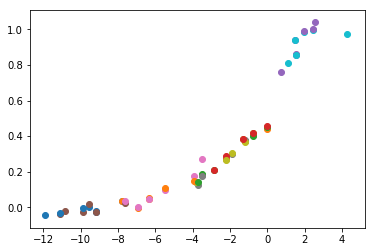

In [94]:
for a,b in zip(E0,EmE0):
    plt.scatter(a,b)

In [ ]:
# will all E-E0 are positive?